In [136]:
%matplotlib inline

from scipy.io import loadmat
import numpy as np
import mne
from mne import create_info
from mne.io import RawArray
from mne.channels import read_montage
import glob

from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
from mne.decoding import CSP
import pandas as pd

In [110]:
filename = "./dataset/001-2014/A01E.mat"

In [111]:
runs = []
event_id = {}
data = loadmat(filename, struct_as_record=False, squeeze_me=True)
run_array = data['data']
for run in run_array:

    ch_names = [
        'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2',
        'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz',
        'EOG1', 'EOG2', 'EOG3'
    ]
    ch_types = ['eeg'] * 22 + ['eog'] * 3    
    
    evd = {}
    n_chan = run.X.shape[1]
    montage = read_montage('standard_1005')
    eeg_data = 1e-6 * run.X
    sfreq = run.fs

    if not ch_names:
        ch_names = ['EEG%d' % ch for ch in range(1, n_chan + 1)]
        montage = None  # no montage

    if not ch_types:
        ch_types = ['eeg'] * n_chan

    trigger = np.zeros((len(eeg_data), 1))
    # some runs does not contains trials i.e baseline runs
    if len(run.trial) > 0:
        trigger[run.trial - 1, 0] = run.y

    eeg_data = np.c_[eeg_data, trigger]
    ch_names = ch_names + ['stim']
    ch_types = ch_types + ['stim']
    evd = {ev: (ii + 1) for ii, ev in enumerate(run.classes)}
    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
    rawi = RawArray(data=eeg_data.T, info=info, verbose=False)    
    
    runs.append(rawi)
    event_id.update(evd)

In [112]:
raw = mne.concatenate_raws(runs)
raw.filter(l_freq=8, h_freq=32, method='iir')

/nethome/coelhorp/anaconda/envs/riemann-lab/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<RawArray  |  None, n_channels x n_times : 26 x 661866 (2647.5 sec), ~131.4 MB, data loaded>

In [113]:
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, event_id={'left hand':1, 'right hand':2}, tmin=2, tmax=6, baseline=None, picks=mne.pick_types(raw.info, eeg=True, stim=False))
X = epochs.get_data()
y = epochs.events[:,-1]

288 events found
Event IDs: [1 2 3 4]
144 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 144 events and 1001 original time points ...
0 bad epochs dropped


In [114]:
pipeline = make_pipeline(CSP(n_components=8), LDA())
cv = StratifiedKFold(5, shuffle=True)
le = LabelEncoder()
y = le.fit_transform(y)
acc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
print(acc.mean())

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
0.6377324263038548


In [117]:
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level("CRITICAL")

def get_session_score(filename, pipeline):
    
    runs = []
    event_id = {}
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    run_array = data['data']
    for run in run_array:

        ch_names = [
            'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2',
            'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz',
            'EOG1', 'EOG2', 'EOG3'
        ]
        ch_types = ['eeg'] * 22 + ['eog'] * 3    

        evd = {}
        n_chan = run.X.shape[1]
        montage = read_montage('standard_1005')
        eeg_data = 1e-6 * run.X
        sfreq = run.fs

        if not ch_names:
            ch_names = ['EEG%d' % ch for ch in range(1, n_chan + 1)]
            montage = None  # no montage

        if not ch_types:
            ch_types = ['eeg'] * n_chan

        trigger = np.zeros((len(eeg_data), 1))
        # some runs does not contains trials i.e baseline runs
        if len(run.trial) > 0:
            trigger[run.trial - 1, 0] = run.y

        eeg_data = np.c_[eeg_data, trigger]
        ch_names = ch_names + ['stim']
        ch_types = ch_types + ['stim']
        evd = {ev: (ii + 1) for ii, ev in enumerate(run.classes)}
        info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
        rawi = RawArray(data=eeg_data.T, info=info, verbose=False)    

        runs.append(rawi)
        event_id.update(evd)    
        
    raw = mne.concatenate_raws(runs)
    raw.filter(l_freq=8, h_freq=32, method='iir')   
    
    events = mne.find_events(raw)
    epochs = mne.Epochs(raw, events, event_id={'left hand':1, 'right hand':2}, tmin=2, tmax=6, baseline=None, picks=mne.pick_types(raw.info, eeg=True, stim=False))
    X = epochs.get_data()
    y = epochs.events[:,-1]    
    
    cv = StratifiedKFold(5, shuffle=True)
    le = LabelEncoder()
    y = le.fit_transform(y)
    acc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
    
    return acc.mean()

In [118]:
pipeline = make_pipeline(CSP(n_components=8), LDA())
score = get_session_score(filename, pipeline)
print(score)

0.6138367346938776


In [132]:
scores = []
subjects = []
sessions = []
for filename in glob.glob('./dataset/001-2014/*'):
    print(filename)

    pipeline = make_pipeline(CSP(n_components=8), LDA())
    score = get_session_score(filename, pipeline)    
    scores.append(score)
    
    session_name = 'session_' + filename.split('.')[1][-1]
    sessions.append(session_name)
    
    subject = int(filename.split('.')[1][-2])    
    subjects.append(subject)
    
results = pd.DataFrame()
results['score'] = scores
results['subject'] = subjects
results['session'] = sessions

./dataset/001-2014/A01E.mat
./dataset/001-2014/A01T.mat
./dataset/001-2014/A02E.mat
./dataset/001-2014/A02T.mat
./dataset/001-2014/A03E.mat
./dataset/001-2014/A03T.mat
./dataset/001-2014/A04E.mat
./dataset/001-2014/A04T.mat
./dataset/001-2014/A05E.mat
./dataset/001-2014/A05T.mat
./dataset/001-2014/A06E.mat
./dataset/001-2014/A06T.mat
./dataset/001-2014/A07E.mat
./dataset/001-2014/A07T.mat
./dataset/001-2014/A08E.mat
./dataset/001-2014/A08T.mat
./dataset/001-2014/A09E.mat
./dataset/001-2014/A09T.mat


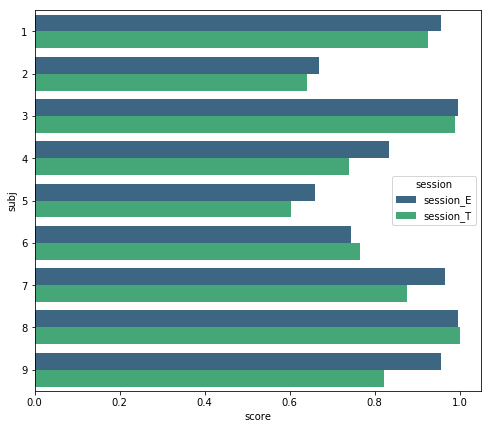

In [139]:
fig, ax = plt.subplots(figsize=(8,7))
results["subj"] = results["subject"].apply(str)
sns.barplot(x="score", y="subj", hue='session', data=results, orient='h', palette='viridis', ax=ax)
#sns.catplot(kind='bar', x="score", y="subj", hue='session', data=results, orient='h', palette='viridis')
fig.show()